## Assignment 5: Design Optimization 

#### Justin Hanson

### Introduction

In this assignment the goat is to create a simulation that could find the optimal stiffness and dampening(as it relates to stiffness) of a hinged joint, that could make a weighted body go as high as possible. 

In [1]:
import os
import mujoco
import numpy
import mediapy as media
import matplotlib.pyplot as plt
import math

First step like always was just to import the necessary libraries for the assignment.

### Part 0. Create the simulated block, leg, and motor

First to create the simulated environment we need to know the exact parameters for the motors that we will be using. This data has been provided to us in the textbook and through parameter identification.

In [2]:
framerate = 30
data_rate = 100
width = 800
height = 600


Next we simply set the parameters for the camera

In [3]:
xml_template = '''
<mujoco>
    <option>
        <flag gravity="enable" contact="enable" />
    </option>
    <option timestep="{ts:e}" />
    <compiler angle="degree" />
    <visual>
        <global offwidth="{width}" offheight="{height}" />
    </visual>

    <default>
        <geom contype="1" conaffinity="1" condim="3" friction="0.6 0.3 0.3" 
              solimp="0.99 0.99 0.01" solref="0.002 1" margin="0.001" />
    </default>

    <worldbody>
        <light name="top" pos="0 0 1" />
        <body name="floor" pos="0 0 0">
            <geom name="floor" pos="0 0 0" size="1 1 .05" type="plane" rgba="1 .83 .61 .5" />
        </body>
        <body name="trunk" pos="0 0 0.1">
            <joint name="joint1" type="slide" axis="0 0 1" />
            <geom name="trunk" pos="0 0.05 0.1" size=".025 .025 .025" type="box" rgba="1 1 0 1" mass=".01" contype="1" conaffinity="1"/>
                <body name="leg_link1" pos="-0.0125 0.05 0">
                <joint name="joint2" type="slide" axis="0 0 1" />
                <geom name="leg_link1" pos="0.025 0 0.025" size=".01 .01 .015" type="box" rgba="0.66 0 1 0.66" mass=".001" contype="1" conaffinity="1" />
                <body name="leg_link2" pos="0 0 0">
                    <joint name="joint3" type="hinge" axis="0 1 0" stiffness="{k:e}" damping="{b:e}" limited="true" range="0 90" />
                    <geom name="leg_link2" pos="0.05 0 0" size="{bsize:e} .01 .01" type="box" rgba="1 0 0 1" mass=".001" />
                </body>
            </body>
        </body>
    </worldbody>

    <actuator>
        <motor name="motor1" joint="joint3" />
    </actuator>
</mujoco>
'''

This XML Generates 1 cube, 1 leg link attached to the bottom edge, and another equal-sized leg connected to the end of the previous one. Finally, it sets a motor to actuate on the connection between the block and the joints. The motor has 180 degrees of motion like a normal servo. Multiple parameters are waiting to be changed when formatting the XML, specifically the width and height of the camera's view, and the stiffness and damping of the leg links. 

In [4]:
def run_sim(k, b, grav, bsize, render=False):
    Vrom = 6
    R = Vrom / 0.6
    G = grav
    t_stall = 15/100/G
    i_stall = .6
    i_nl = .2
    w_nl = .66*1000*2*math.pi/180*G

    kt = t_stall/i_stall
    ke = kt

    b_calc = kt*i_nl/w_nl
    ts = 1e-4

    V_control = 5
    b_fit = 1.404e-6
    kp_fit = 8.896
    xml = xml_template.format(k=k, b=b, width=width, height=height, bsize=bsize, ts=ts)
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model, width=width, height=height)

    # Set the initial angle of joint2 (in radians)
    def my_controller(model, data):
        w = data.qvel[1]
        actual = data.qpos[1]
        if data.time > 1:
            desired = math.pi
        else:
            desired = 0

        error = desired - actual
        V = kp_fit * error
        if V > V_control:
            V = V_control
        if V < -V_control:
            V = -V_control

        torque = (kt * (V - (ke) * w * G) / R - b_fit * w * G) * G

        data.ctrl[0] = torque

        return
    try:
        mujoco.set_mjcb_control(my_controller)
        duration = 5

        frames = []
        t = []
        xy = []

        mujoco.mj_resetData(model, data)

        while data.time < duration:
            mujoco.mj_step(model, data)

            if render:
                if len(frames) < data.time * framerate:
                    renderer.update_scene(data)
                    pixels = renderer.render()
                    frames.append(pixels)

            if len(xy) < data.time * data_rate:
                t.append(data.time)
                xy.append(data.xpos.copy())

        if render:
            media.show_video(frames, fps=framerate, codec='gif')
        t = numpy.array(t)
        xy = numpy.array(xy)
    finally:
        mujoco.set_mjcb_control(None)
    
    return t, xy, frames

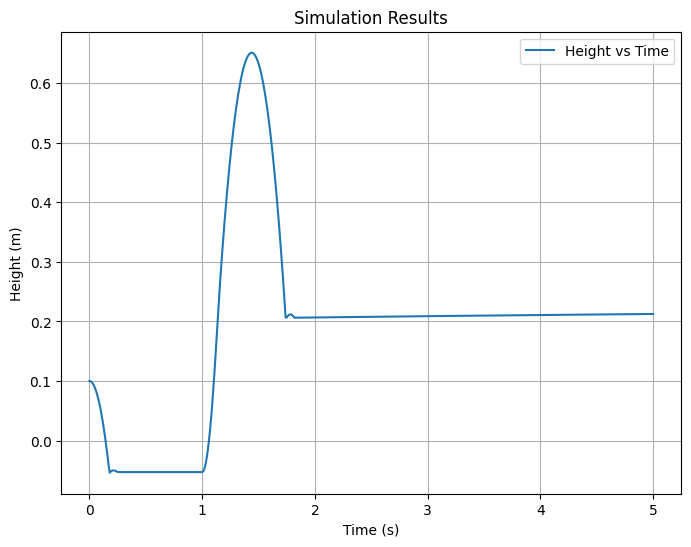

""

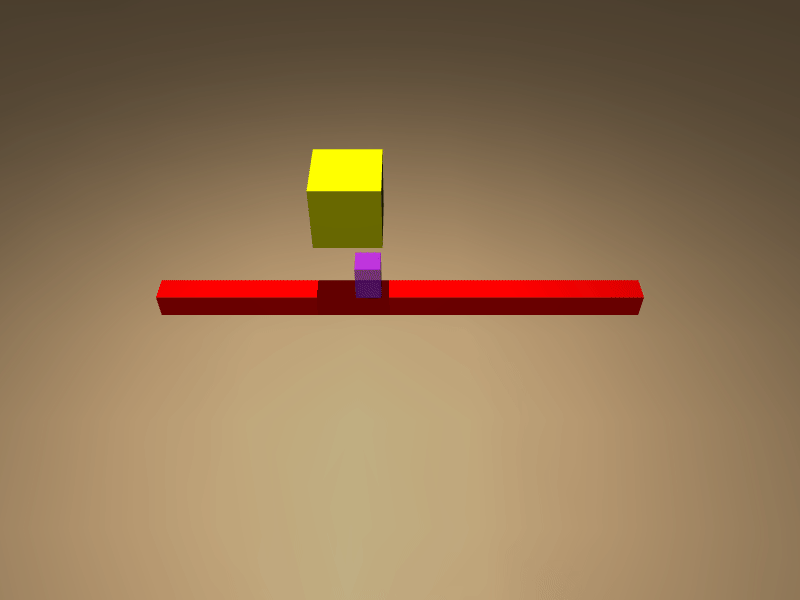

Button(description='Reset Simulation', style=ButtonStyle())

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import threading
import matplotlib.pyplot as plt

# Function to run the simulation with slider values
def run_sim_with_gui(k, b, g, body_size, render=False):
    print(f"Running simulation with stiffness={k}, damping={b}, gravity={g}, body_size={body_size}")
    # Update global variables for the simulation
    global stiff, damp, grav
    stiff = k
    damp = b
    grav = g

    # Run the simulation
    t, xy, frames = run_sim(k, b, g, body_size, render=render)

    # Clear previous output and display the results
    clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.plot(t, xy[:, 2, 2], label="Height vs Time")
    plt.title("Simulation Results")
    plt.xlabel("Time (s)")
    plt.ylabel("Height (m)")
    plt.legend()
    plt.grid()
    plt.show()

    # Optionally display the video if render=True
    if render:
        import mediapy as media
        media.show_video(frames, fps=30, codec="gif")

    # Display the reset button after the simulation
    display(reset_button)

# Function to handle the "Run Simulation" button click
def on_run_button_clicked(b):
    k = stiffness_slider.value*10**-2
    b = damping_slider.value*10**-2/100
    g = gravity_slider.value
    body_size = body_size_slider.value

    # Run the simulation in a separate thread to avoid freezing the notebook
    threading.Thread(target=run_sim_with_gui, args=(k, b, g, body_size, True)).start()

# Function to reset the simulation and bring back the GUI
def on_reset_button_clicked(b):
    clear_output(wait=True)
    display_gui()

# Function to display the GUI
def display_gui():
    display(stiffness_slider, damping_slider, gravity_slider, body_size_slider, run_button)

# Create sliders
stiffness_slider = widgets.FloatSlider(value=0.05, min=0.05, max=3, step=0.005, description='Stiffness:')
damping_slider = widgets.FloatSlider(value=0.05, min=0.05, max=3, step=0.005, description='Damping:')
gravity_slider = widgets.FloatSlider(value=9.8, min=0.01, max=100, step=0.01, description='Gravity:')
body_size_slider = widgets.FloatSlider(value=0.025, min=0.001, max=1, step=0.001, description='Body Size:')

# Create buttons
run_button = widgets.Button(description="Run Simulation")
run_button.on_click(on_run_button_clicked)

reset_button = widgets.Button(description="Reset Simulation")
reset_button.on_click(on_reset_button_clicked)

# Display the GUI
display_gui()

In [6]:
zs = []
ks = []
exps = numpy.r_[0.05:3:.01]

for exp in exps:
    k = exp*10**(-2)
    ks.append(k)
    b = k/100
    t,xy,frames = run_sim(k,b,gravity_slider.value,body_size_slider.value,render=False)
    max_z = xy[:,2,2].max()
    #print(max_z)
    zs.append(max_z)

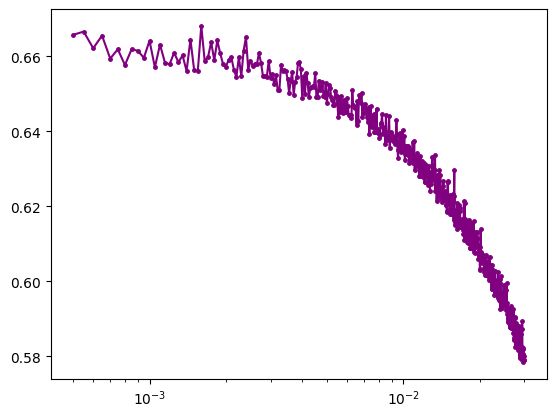

In [8]:
mainplot = plt.semilogx(ks,zs, marker = ".",
            markersize = 5,
            color = "purple")


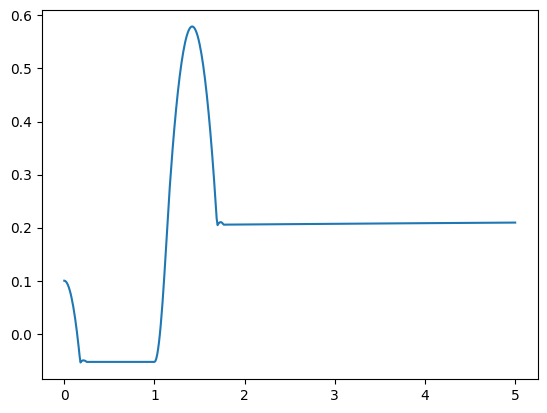

In [9]:
plt.plot(t,xy[:,2,2])

In [10]:
iis = numpy.r_[0:100:1]
for i in iis:
    if i < len(zs):
        print(zs[i])



0.665672618836287
0.666545907770261
0.6621081623491782
0.6654706046531371
0.6593581063482394
0.6618351236224664
0.6576359428332045
0.6618322937889431
0.6614291643502881
0.6595536644229962
0.6640944515984005
0.6570445336283258
0.6630826566313619
0.6583015747495587
0.6578260963331533
0.6609068109730887
0.6583932550729791
0.6601818917500945
0.6560556749688611
0.664415693748672
0.6562172487226668
0.6560438252487262
0.6680656805494403
0.658767103570549
0.6596798615700012
0.6637333087154517
0.658902002677321
0.6641795891700998
0.660736730183068
0.6578111987526729
0.657181023517497
0.6589875178718825
0.6598064587809872
0.656423330653047
0.6544030405584711
0.6597528650658795
0.6546352714103173
0.6615026680733713
0.6650827262733752
0.6563664332796313
0.6587879182767165
0.6574482749218779
0.6580027692588535
0.6578289537325211
0.6607860184986133
0.6582990904445454
0.6547199713871312
0.6545857501837767
0.6544058905731445
0.6587719917270447
0.6542082538554834
0.6551886595480966
0.6525303451495097
0

Due to the simulation break in the final 4 data points, I will truncate the list so that it only includes the datapoints that have reliable maximum heights.

In [11]:
import scipy.optimize as optimize
import numpy as np

DaZs = zs
def max_k():
    maxp = 0
    def objective_function(zVal):
        return -zVal
    
    result = optimize.minimize_scalar(objective_function, bounds=(min(DaZs), max(DaZs)), method='bounded')
    #print(result.x)
    allks = numpy.r_[0:370:1]
    for kp in allks:
        #display(kp, round(result.x, 4) , round(zs[kp],4))
        if kp < len(zs):
            if round(result.x,4) == round(zs[kp],4):
                #print("RIGHT HEREEE")
                maxp = kp
    return maxp

maxPoint = max_k()

print("Optimal Index:",maxPoint)
print("Optimal Stiffness:",ks[maxPoint])
print("Max Height:",zs[maxPoint])

Optimal Index: 22
Optimal Stiffness: 0.0015999999999999994
Max Height: 0.6680656805494403


Above I wrote a function that takes the list of zs and performs a minimize function that makes all the zs negative so it finds the smallest(largest) z value. Then to find the index of that value in k and returned that value. Finally I printed the index, the value of k at that index, and the value of z at that index. Now I had the highest height that the box went for the optimal k value.

To plot the point on the origional plot, I simply plotted it again and added the new found optimal stiffness point. The optimal point is in red

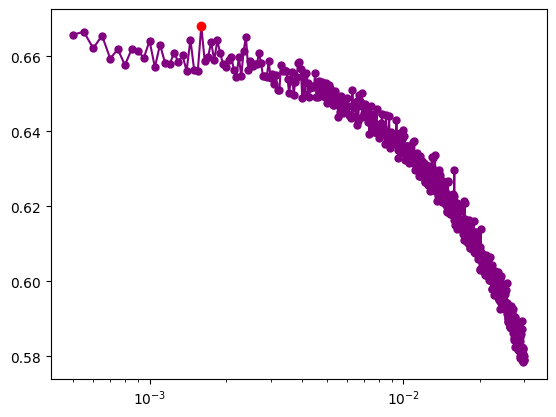

In [12]:
plt.semilogx(ks,zs, marker = ".",
            markersize = 10,
            color = "purple")
plt.plot(ks[maxPoint],zs[maxPoint], "or")

Here is the video of the optimal jump.

""

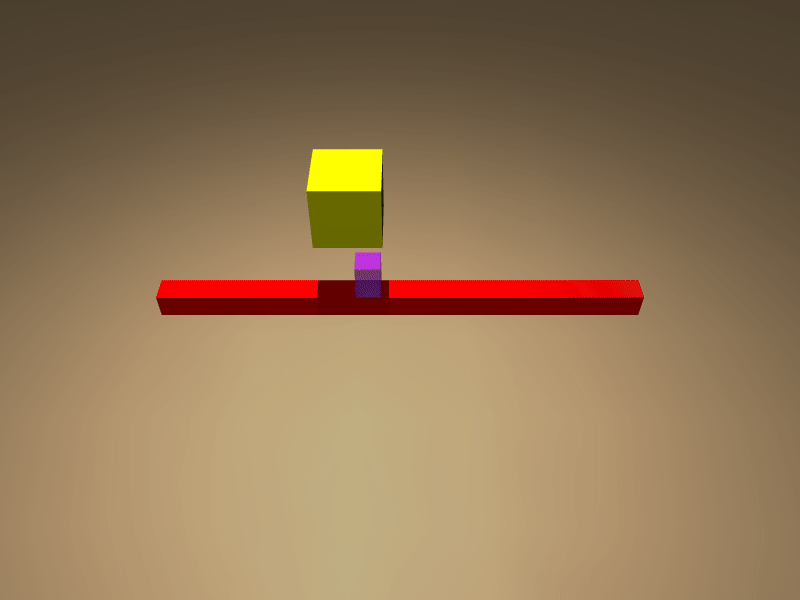

In [15]:
t,xy, frames = run_sim(ks[maxPoint], ks[maxPoint]/100,gravity_slider.value, body_size_slider.value, render=True)

Here is the graph of the height graph for the optimal jump

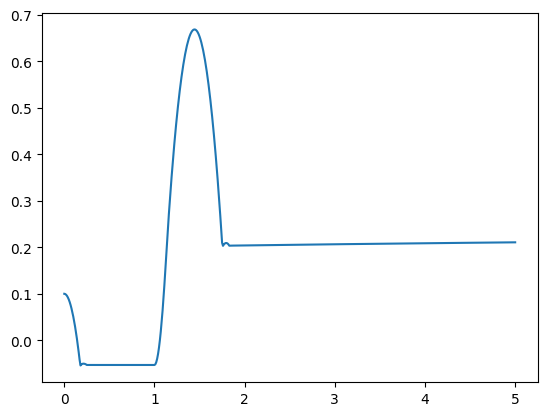

In [16]:
plt.plot(t,xy[:,2,2])